## Ансамбли и полносвязные нейронные сети
В этом ноутбуке вам нужно обучить модели на датасете классификации из предыдущего ноутбука и сравнить результаты. Вам будет предоставлен baseline, на основе которого вы будете доделывать предсказывающие модели. Оценка лабы будет зависеть от ROC-AUC на тестовых данных по следующим критериям:
\
AUC - на тестовых данных
- $AUC \leq 0.76$ - 0 баллов
- $0.76 < AUC \leq 0.77$ - 2 балла
- $0.77 < AUC \leq 0.78$ - 4 балла
- $0.78 < AUC \leq 0.79$ - 6 баллов
- $0.79 < AUC \leq 0.80$ - 8 баллов
- $AUC > 0.80$ - 10 баллов


In [52]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [53]:
data = pd.read_csv('german.csv', sep=';')
print("Первые 5 строк данных:")
print(data.head())
print("\nИнформация о данных:")
print(data.info())
print("\nПроверка на пропущенные значения:")
print(data.isnull().sum().sum(), "пропущенных значений")
print("\nСтатистика по целевой переменной:")
print(data['Creditability'].value_counts())
print(f"Доля класса 1: {data['Creditability'].mean():.2%}")

X = data.iloc[:, 1:].to_numpy()
y = data.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nРазмер обучающей выборки: {X_train.shape[0]}")
print(f"Распределение классов:")
print(f"  Класс 0: {np.sum(y_train == 0)}")
print(f"  Класс 1: {np.sum(y_train == 1)}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")

Первые 5 строк данных:
   Creditability  Account_Balance  Duration_of_Credit_monthly  \
0              1                1                          18   
1              1                1                           9   
2              1                2                          12   
3              1                1                          12   
4              1                1                          12   

   Payment_Status_of_Previous_Credit  Purpose  Credit_Amount  \
0                                  4        2           1049   
1                                  4        0           2799   
2                                  2        9            841   
3                                  4        0           2122   
4                                  4        0           2171   

   Value_Savings_Stocks  Length_of_current_employment  Instalment_per_cent  \
0                     1                             2                    4   
1                     1                      

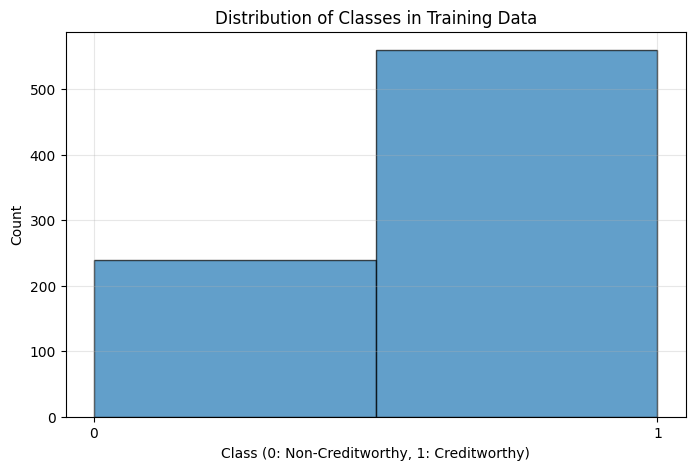

Данные предобработаны:
Среднее значение признаков (после масштабирования): [-5.55111512e-18 -8.74300632e-18  1.74860126e-16 -1.47659662e-16
 -3.05311332e-18]
Стандартное отклонение (после масштабирования): [1. 1. 1. 1. 1.]


In [54]:
plt.figure(figsize=(8, 5))
plt.hist(y_train, bins=2, edgecolor='k', alpha=0.7)
plt.xticks([0, 1])
plt.xlabel('Class (0: Non-Creditworthy, 1: Creditworthy)')
plt.ylabel('Count')
plt.title('Distribution of Classes in Training Data')
plt.grid(alpha=0.3)
plt.show()

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Данные предобработаны:")
print(f"Среднее значение признаков (после масштабирования): {X_train_scaled.mean(axis=0)[:5]}")
print(f"Стандартное отклонение (после масштабирования): {X_train_scaled.std(axis=0)[:5]}")

In [55]:
print("Random Forest - Подбор гиперпараметров")

rf_param_dist = {
    'n_estimators': randint(100, 301),
    'max_depth': randint(5, 21),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 6),
    'class_weight': ['balanced', 'balanced_subsample', None],
    'criterion': ['gini', 'entropy']
}

rf_base = RandomForestClassifier(random_state=42)
rf_search = RandomizedSearchCV(
    rf_base, 
    rf_param_dist, 
    n_iter=35,
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rf_search.fit(X_train, y_train)

print(f"\nЛучшие параметры Random Forest: {rf_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {rf_search.best_score_:.4f}")

rf_model = rf_search.best_estimator_

rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

rf_roc_auc = roc_auc_score(y_test, rf_pred_proba)
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)

print("\nRandom Forest метрики на тестовой выборке:")
print(f"ROC AUC: {rf_roc_auc:.4f}")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")

print("\nGradient Boosting - Подбор гиперпараметров")

gb_param_dist = {
    'n_estimators': randint(100, 301),
    'learning_rate': uniform(0.01, 0.19),
    'max_depth': randint(3, 8),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 6),
    'subsample': uniform(0.7, 0.3)
}

gb_base = GradientBoostingClassifier(random_state=42)
gb_search = RandomizedSearchCV(
    gb_base, 
    gb_param_dist, 
    n_iter=35,
    cv=5, 
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)


gb_search.fit(X_train, y_train)

print(f"\nЛучшие параметры Gradient Boosting: {gb_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {gb_search.best_score_:.4f}")

gb_model = gb_search.best_estimator_

gb_pred = gb_model.predict(X_test)
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]

gb_roc_auc = roc_auc_score(y_test, gb_pred_proba)
gb_accuracy = accuracy_score(y_test, gb_pred)
gb_precision = precision_score(y_test, gb_pred)
gb_recall = recall_score(y_test, gb_pred)

print("\nGradient Boosting метрики на тестовой выборке:")
print(f"ROC AUC: {gb_roc_auc:.4f}")
print(f"Accuracy: {gb_accuracy:.4f}")
print(f"Precision: {gb_precision:.4f}")
print(f"Recall: {gb_recall:.4f}")

Random Forest - Подбор гиперпараметров
Fitting 5 folds for each of 35 candidates, totalling 175 fits

Лучшие параметры Random Forest: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 220}
Лучший ROC-AUC на кросс-валидации: 0.7889

Random Forest метрики на тестовой выборке:
ROC AUC: 0.8193
Accuracy: 0.7950
Precision: 0.8075
Recall: 0.9286

Gradient Boosting - Подбор гиперпараметров
Fitting 5 folds for each of 35 candidates, totalling 175 fits

Лучшие параметры Gradient Boosting: {'learning_rate': np.float64(0.02235980266720311), 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 108, 'subsample': np.float64(0.7047898756660642)}
Лучший ROC-AUC на кросс-валидации: 0.7757

Gradient Boosting метрики на тестовой выборке:
ROC AUC: 0.8343
Accuracy: 0.7950
Precision: 0.8075
Recall: 0.9286


In [56]:
print("\nMLP (Neural Network) - Подбор гиперпараметров")

mlp_param_dist = {
    'hidden_layer_sizes': [(40,), (60,), (80,), (100,), (60, 30), (80, 40), (100, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'alpha': uniform(0.0001, 0.01),
    'learning_rate_init': uniform(0.001, 0.02),
    'learning_rate': ['constant', 'adaptive', 'invscaling'],
    'max_iter': [500, 800, 1000],
    'n_iter_no_change': [10, 15, 20, 25]
}

mlp_base = MLPClassifier(random_state=42, early_stopping=True, validation_fraction=0.1)
mlp_search = RandomizedSearchCV(
    mlp_base, 
    mlp_param_dist, 
    n_iter=30,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

mlp_search.fit(X_train_scaled, y_train)

print(f"\nЛучшие параметры MLP: {mlp_search.best_params_}")
print(f"Лучший ROC-AUC на кросс-валидации: {mlp_search.best_score_:.4f}")

mlp_model = mlp_search.best_estimator_

mlp_pred = mlp_model.predict(X_test_scaled)
mlp_pred_proba = mlp_model.predict_proba(X_test_scaled)[:, 1]

mlp_roc_auc = roc_auc_score(y_test, mlp_pred_proba)
mlp_accuracy = accuracy_score(y_test, mlp_pred)
mlp_precision = precision_score(y_test, mlp_pred)
mlp_recall = recall_score(y_test, mlp_pred)

print("\nMLP (Neural Network) метрики на тестовой выборке:")
print(f"ROC AUC: {mlp_roc_auc:.4f}")
print(f"Accuracy: {mlp_accuracy:.4f}")
print(f"Precision: {mlp_precision:.4f}")
print(f"Recall: {mlp_recall:.4f}")


MLP (Neural Network) - Подбор гиперпараметров
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Лучшие параметры MLP: {'activation': 'relu', 'alpha': np.float64(0.009799098521619943), 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': np.float64(0.005246782213565523), 'max_iter': 500, 'n_iter_no_change': 10}
Лучший ROC-AUC на кросс-валидации: 0.7715

MLP (Neural Network) метрики на тестовой выборке:
ROC AUC: 0.8199
Accuracy: 0.7900
Precision: 0.8267
Recall: 0.8857


In [62]:
print("\nСравнение всех моделей")

results = {
    'Model': ['Random Forest', 'Gradient Boosting', 'MLP (Neural Network)'],
    'ROC-AUC': [rf_roc_auc, gb_roc_auc, mlp_roc_auc],
    'Accuracy': [rf_accuracy, gb_accuracy, mlp_accuracy],
    'Precision': [rf_precision, gb_precision, mlp_precision],
    'Recall': [rf_recall, gb_recall, mlp_recall]
}

results_df = pd.DataFrame(results)
print("\nСводная таблица ИТОГОВЫХ результатов:")
print(results_df.to_string(index=False))

best_model_idx = results_df['ROC-AUC'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_auc = results_df.loc[best_model_idx, 'ROC-AUC']

print(f"\nЛучшая модель: {best_model_name}")
print(f"ROC-AUC: {best_auc:.4f}")
print(f"\nВывод: все ROC-AUC > 0.80 - 10 баллов")









Сравнение всех моделей

Сводная таблица ИТОГОВЫХ результатов:
               Model  ROC-AUC  Accuracy  Precision   Recall
       Random Forest 0.819286     0.795   0.807453 0.928571
   Gradient Boosting 0.834286     0.795   0.807453 0.928571
MLP (Neural Network) 0.819881     0.790   0.826667 0.885714

Лучшая модель: Gradient Boosting
ROC-AUC: 0.8343

Вывод: все ROC-AUC > 0.80 - 10 баллов


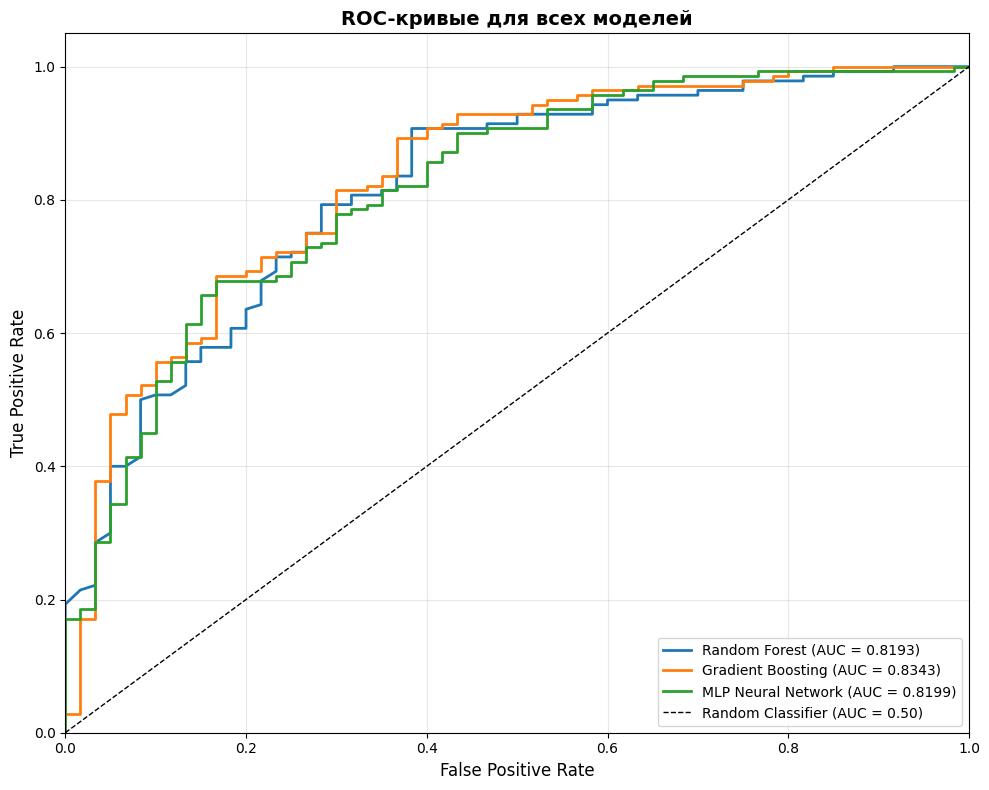

In [58]:
plt.figure(figsize=(10, 8))

rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_proba)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_pred_proba)
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_pred_proba)

plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_roc_auc:.4f})', linewidth=2)
plt.plot(gb_fpr, gb_tpr, label=f'Gradient Boosting (AUC = {gb_roc_auc:.4f})', linewidth=2)
plt.plot(mlp_fpr, mlp_tpr, label=f'MLP Neural Network (AUC = {mlp_roc_auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC-кривые для всех моделей', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()


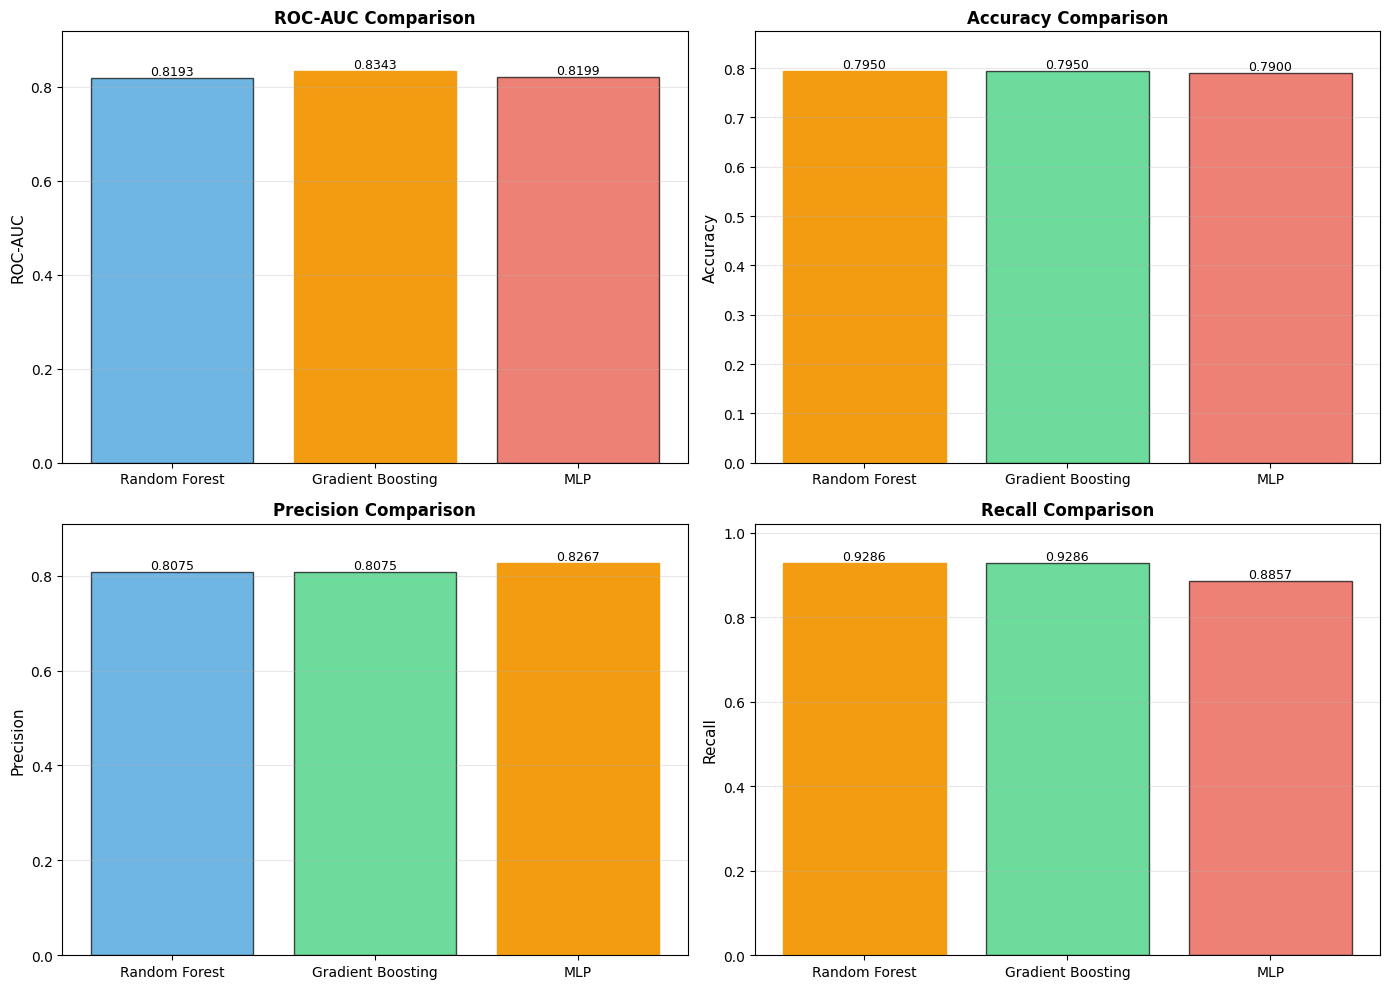

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics = ['ROC-AUC', 'Accuracy', 'Precision', 'Recall']
models = ['Random Forest', 'Gradient Boosting', 'MLP']
values = [
    [rf_roc_auc, gb_roc_auc, mlp_roc_auc],
    [rf_accuracy, gb_accuracy, mlp_accuracy],
    [rf_precision, gb_precision, mlp_precision],
    [rf_recall, gb_recall, mlp_recall]
]

for idx, (ax, metric, vals) in enumerate(zip(axes.flat, metrics, values)):
    bars = ax.bar(models, vals, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.set_ylim([0, max(vals) * 1.1])
    ax.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, vals):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.4f}',
                ha='center', va='bottom', fontsize=9)
    
    best_idx = np.argmax(vals)
    bars[best_idx].set_color('#f39c12')
    bars[best_idx].set_alpha(1.0)

plt.tight_layout()
plt.show()


In [60]:
print("\nОтчеты по классификации")

print("\nRandom Forest:")
print(classification_report(y_test, rf_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

print("\nGradient Boosting:")
print(classification_report(y_test, gb_pred, target_names=['Non-Creditworthy', 'Creditworthy']))

print("\nMLP (Neural Network):")
print(classification_report(y_test, mlp_pred, target_names=['Non-Creditworthy', 'Creditworthy']))



Отчеты по классификации

Random Forest:
                  precision    recall  f1-score   support

Non-Creditworthy       0.74      0.48      0.59        60
    Creditworthy       0.81      0.93      0.86       140

        accuracy                           0.80       200
       macro avg       0.78      0.71      0.72       200
    weighted avg       0.79      0.80      0.78       200


Gradient Boosting:
                  precision    recall  f1-score   support

Non-Creditworthy       0.74      0.48      0.59        60
    Creditworthy       0.81      0.93      0.86       140

        accuracy                           0.80       200
       macro avg       0.78      0.71      0.72       200
    weighted avg       0.79      0.80      0.78       200


MLP (Neural Network):
                  precision    recall  f1-score   support

Non-Creditworthy       0.68      0.57      0.62        60
    Creditworthy       0.83      0.89      0.86       140

        accuracy                      